In [1]:
import mlflow
from mlflow.tracking import client
import xarray as xr
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
from analysis.utils import select_experiment, select_run, plot_dataset, GlobalPlotter, anomalies
from data.pangeo_catalog import get_whole_data
from data.xrtransforms import SeasonalStdizer, TargetedTransform, ScalingTransform
from dask.diagnostics import ProgressBar
from models.submodels import transform3

import cartopy.crs as ccrs
import cmocean

cmap = cmocean.cm.balance
cmap_balance = cmocean.cm.balance
cmap_balance_r=cmocean.cm.balance_r

cmap_amp = cmocean.cm.amp

plt.rcParams["figure.figsize"] = (4, 4 / 1.618)

uv_plotter = GlobalPlotter() 
uv_plotter.x_ticks = np.arange(-150., 151., 50)
uv_plotter.y_ticks = np.arange(-80., 81., 20)


%matplotlib notebook


/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/intake/source/discovery.py:285: UserWarning: Plugin name collision for "netcdf" from
    /home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/intake_iris/netcdf.py
and
    /home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/intake_xarray/netcdf.py
Keeping plugin from first location.
  % (plugin_name, orig_path, new_path))


Using cached version!
Using cached version!


In [2]:
CATALOG_URL = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore\
/master/intake-catalogs/master.yaml'
data = get_whole_data(CATALOG_URL, 0)
grid_info = data[1]
# mask = grid_info['wet'].coarsen(dict(xt_ocean=4, yt_ocean=4))
# mask_ = mask.max()
# mask_ = mask_.where(mask_ > 0.1)

Using cached version!
Using cached version!


In [3]:
test_exp_name = select_experiment()
test_exp = mlflow.get_experiment_by_name(test_exp_name)
test_exp_id = test_exp.experiment_id
run = select_run(experiment_ids=test_exp_id, cols=['status', 'start_time', 'params.CO2', 'params.factor',
                                                  'params.submodel'],
                merge=[('data-global', 'params.data_run_id', 'run_id'),
                      ('modelsv1', 'params.model_run_id', 'run_id')])
client_ = client.MlflowClient()
data_file_name = client_.download_artifacts(run['params.data_run_id'], 'forcing')
print('Data path:', data_file_name)
data = xr.open_zarr(data_file_name)
data = data.rename({'xu_ocean': 'longitude', 'yu_ocean': 'latitude'})
data = data * 1e7
pred_file_name = client_.download_artifacts(run.run_id, 'test_output_0')
pred = xr.open_zarr(pred_file_name)
data = data.sel(time=slice(pred.time[0], pred.time[-1])).sel(latitude=slice(pred.latitude[0], pred.latitude[-1]))

6 :  multiregion
17 :  meeting22july
15 :  datacm21
21 :  modelsv1
3 :  multiregions
19 :  data-global
14 :  forcingdatav3
2 :  training
4 :  default
7 :  Unet
18 :  forcing-data-global
12 :  test
9 :  forcingdata1pct
5 :  regionsfortraining
20 :  test_global
8 :  arctan
16 :  meeting15july
13 :  forcingdatav2
Select the id of an experiment: 4
                              run_id experiment_id    status  \
0   9fa14fcb81054084b45634770278789b             4   RUNNING   
1   08d1c3445ffe4de2b50944cab1220140             4   RUNNING   
2   23cac34c4c654189adb5011067725ee1             4   RUNNING   
3   4340ea02b2d74f1db37da26dcb04197f             4  FINISHED   
4   dfc61b690a3e4831bddd709fb91f42ed             4   RUNNING   
5   b730ea7738a743d88d90a469eae72970             4   RUNNING   
6   ab4d237496e6450383d74ed2da243c22             4   RUNNING   
7   1687a9a7d1f74866a9803897226b0b19             4  FINISHED   
8   8b70fb93ea484452913f61b1ddad373f             4   RUNNING   
9   b2f3efd050

In [5]:
lon = slice(None, None, 1)
lat= slice(-80, 80, 1)
time_slice = slice(None, None, 1)

p0 = pred['0'].sel(longitude=lon, latitude=lat).isel(time=time_slice)
p1 = pred['1'].sel(longitude=lon, latitude=lat).isel(time=time_slice)
p0 = np.exp(p0) / (np.exp(p0) + np.exp(p1))
p1 = 1 - p0
# Means
mu0 = pred['4'].sel(longitude=lon, latitude=lat).isel(time=time_slice)
mu1 = pred['8'].sel(longitude=lon, latitude=lat).isel(time=time_slice)
true = data['S_x'].sel(longitude=lon, latitude=lat).isel(time=time_slice)
# precisions
beta0 = pred['6'].sel(longitude=lon, latitude=lat).isel(time=time_slice)
beta1 = pred['10'].sel(longitude=lon, latitude=lat).isel(time=time_slice)

In [ ]:
def apply_complete_mask(array):
    mask = uv_plotter.borders
    mask2 = uv_plotter.mask
    mask = mask.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    mask2 = mask2.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    array = array.where(np.isnan(mask) & (~np.isnan(mask2)))
    array = array.sel(latitude=slice(pred['latitude'][0], pred['latitude'][-1]))
    return array

## Time series analysis

<IPython.core.display.Javascript object>


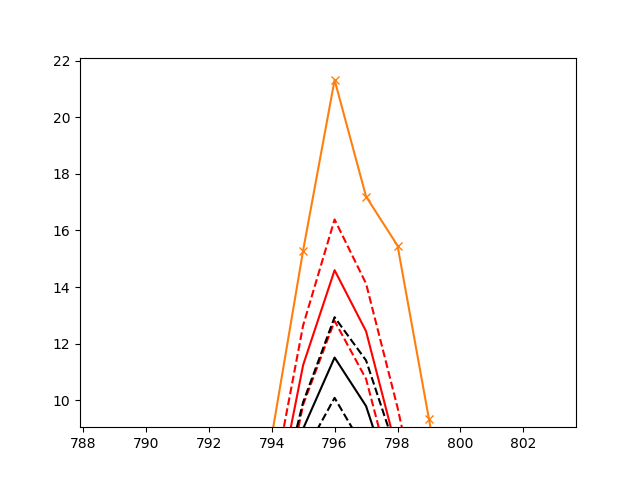

In [32]:
lon = -129
lat= -55

p0_ = p0.sel(longitude=lon, latitude=lat, method='nearest')
mu0_ = mu0.sel(longitude=lon, latitude=lat, method='nearest')
mu1_ = mu1.sel(longitude=lon, latitude=lat, method='nearest')
beta0_ = beta0.sel(longitude=lon, latitude=lat, method='nearest')
beta1_ = beta1.sel(longitude=lon, latitude=lat, method='nearest')
true_ = true.sel(longitude=lon, latitude=lat, method='nearest')

plt.figure()
plt.plot(p0_)
plt.plot(true_, '-x')
plt.plot(mu0_, 'r')
plt.plot(mu1_, 'k')
plt.plot(mu0_ -1.96 * 1 / beta0_, '--r')
plt.plot(mu0_ + 1.96 * 1 / beta0_, '--r')
plt.plot(mu1_ - 1.96 * 1 / beta1_, '--k')
plt.plot(mu1_ + 1.96 * 1 / beta1_, '--k')

In [33]:
time = 796
n_samples = 1000000
sel = np.random.rand(n_samples) > float(p0_.isel(time=time))
sel = np.arange(n_samples) + sel * n_samples
samples0 = np.random.randn(n_samples) / float(beta0_.isel(time=time)) + float(mu0_.isel(time=time))
samples1 = np.random.randn(n_samples) / float(beta1_.isel(time=time)) + float(mu1_.isel(time=time))
samples = np.concatenate((samples0, samples1))
final_samples = samples[sel]

<IPython.core.display.Javascript object>


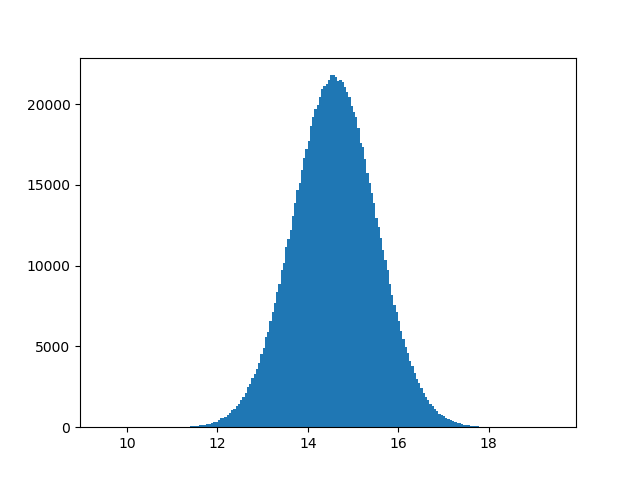

21.315623418120033


In [35]:
plt.figure()
print(float(true_.isel(time=time)))
_ = plt.hist(final_samples, bins=200)

## Global distribution of true and simulated forcing

We assess the goodness of fit

### Likelihood map

In [36]:
from scipy.stats import norm

In [8]:
def pdf(x, p0, mu0, beta0, mu1, beta1):
    return p0 * norm.pdf((x - mu0) * beta0) + (1 - p0) * norm.pdf((x - mu1) * beta1)

lkh = pdf(true, p0, mu0, beta0, mu1, beta1)

<IPython.core.display.Javascript object>


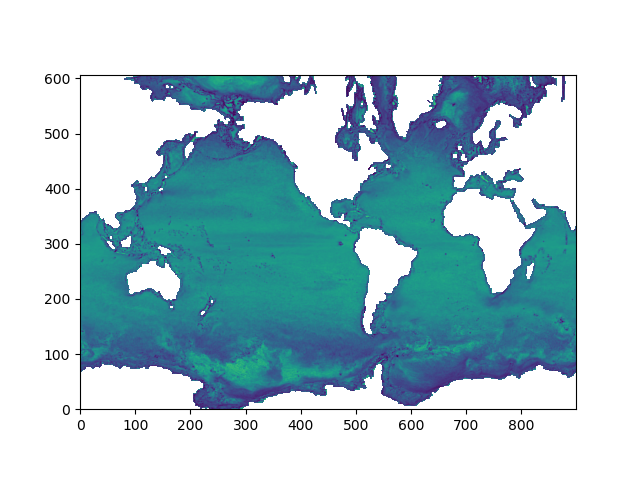

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [38]:
plt.figure()
plt.imshow(lkh.mean(dim='time'), origin='lower', vmin=0, vmax=0.5)

### Mean likelihood

In [32]:
lat = slice(-40, 40)
with ProgressBar():
    mean_lkh = apply_complete_mask(lkh.sel(latitude=lat)).mean().compute()

[#################                       ] | 42% Completed | 14.4s


KeyboardInterrupt: 

In [33]:
mean_lkh

<xarray.DataArray ()>
array(0.24976554)

### Goodness of fit

In [6]:
from scipy.stats import norm
def my_transform(x ,p0, mu0, beta0, mu1, beta1):
    cdf = lambda x: p0 * norm.cdf((x - mu0) * beta0) + (1 - p0) * norm.cdf((x - mu1) * beta1)
    return cdf(x)

v = my_transform(true, p0, mu0, beta0, mu1, beta1)
v = v.sel(latitude=slice(-40, 40))
v = apply_complete_mask(v)

In [22]:
v

,Array,Chunk
Bytes,1.57 GB,50.23 MB
Shape,"(1000, 218, 900)","(32, 218, 900)"
Count,583 Tasks,32 Chunks
Type,float64,numpy.ndarray


<IPython.core.display.Javascript object>


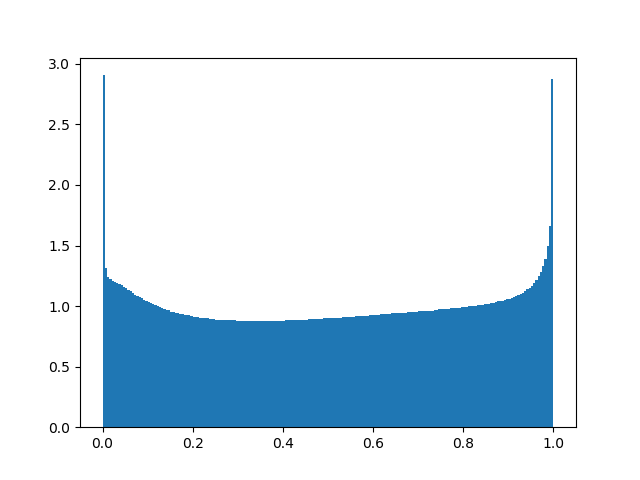

In [74]:
plt.figure()
_ = plt.hist(v.values.flatten(), bins=200, density=True)

In [80]:
v.shape

(1000, 218, 900)

In [16]:
quantiles = np.exp(np.linspace(-10, 10, 100)) / (1 + np.exp(np.linspace(-10, 10, 100)))

q = np.nanquantile(v, quantiles)

<IPython.core.display.Javascript object>


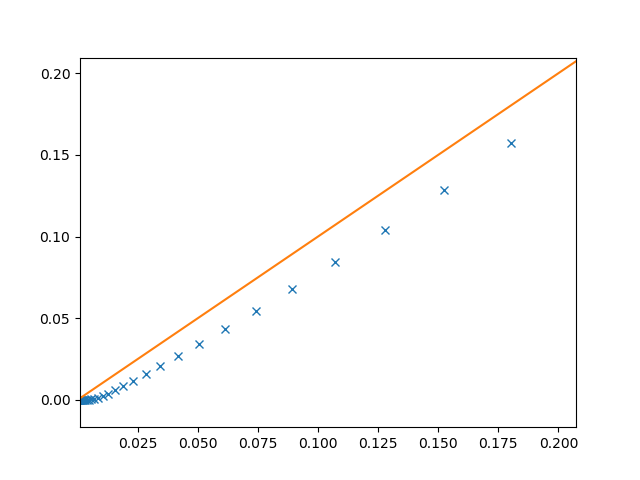

In [18]:
plt.figure()
plt.plot(quantiles, q, 'x')
plt.plot(quantiles, quantiles)

In [78]:
norm.ppf(0.001)

-3.090232306167813

<IPython.core.display.Javascript object>


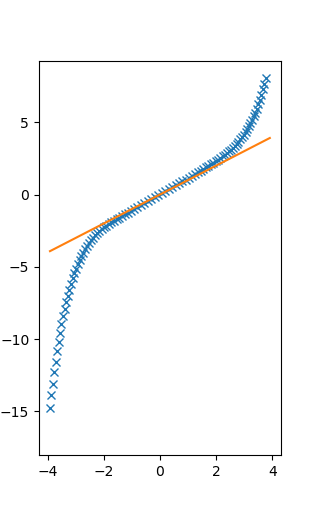

(-4.305352916492039, 4.305352916492273, -18.0, 9.217679542913634)

In [28]:
from scipy.stats import norm
s = norm.ppf(q)
plt.figure()
plt.plot(norm.ppf(quantiles),  s, 'x')
plt.plot(norm.ppf(quantiles),  norm.ppf(quantiles))
plt.axis([None, None, -18, None])


## Distribution of simulated vs true forcing

In [77]:
saved_true = true

In [94]:
def apply_complete_mask(array):
    mask = uv_plotter.borders
    mask2 = uv_plotter.mask
    mask = mask.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    mask2 = mask2.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    array = array.where(np.isnan(mask) & (~np.isnan(mask2)))
    array = array.sel(latitude=slice(pred['latitude'][0], pred['latitude'][-1]))
    return array

true = apply_complete_mask(saved_true)

epsilon = np.random.randn(*true.shape)
epsilon2 = np.random.randn(*true.shape)
bernouilli = np.random.rand(*true.shape) > p0
simulated = bernouilli * (mu0 + epsilon / beta0) + (1 - bernouilli) * (mu1 + epsilon / beta1)

simulated = apply_complete_mask(simulated)


<IPython.core.display.Javascript object>


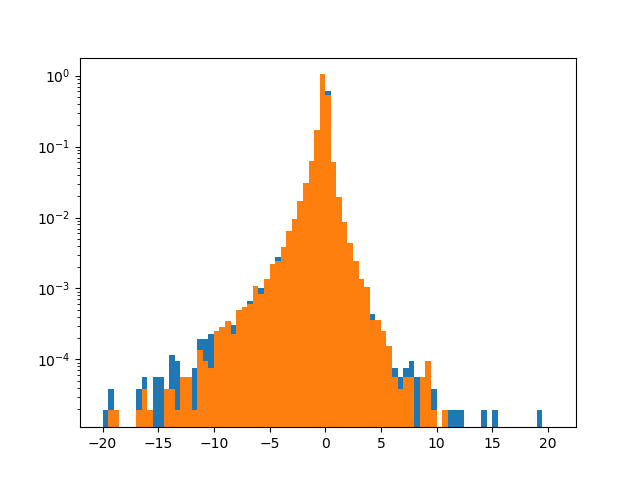

In [71]:
plt.figure()
_ = plt.hist(true.values.ravel(), log=True, bins=np.arange(-20, 21, 0.5), density=True)
_ = plt.hist(simulated.values.ravel(), log=True, bins=np.arange(-20, 21, 0.5), density=True)


In [92]:
quantiles = np.exp(np.linspace(-3, 3, 100)) / (1 + np.exp(np.linspace(-3, 3, 100)))
quantiles

array([0.04742587, 0.05024018, 0.05321217, 0.05634954, 0.05966022,
       0.0631524 , 0.06683447, 0.07071501, 0.0748028 , 0.07910678,
       0.08363602, 0.08839968, 0.093407  , 0.09866727, 0.10418972,
       0.10998355, 0.11605783, 0.12242144, 0.12908302, 0.13605089,
       0.14333299, 0.15093676, 0.1588691 , 0.16713627, 0.17574374,
       0.1846962 , 0.19399737, 0.20364993, 0.21365546, 0.22401429,
       0.23472544, 0.24578652, 0.25719365, 0.26894142, 0.28102278,
       0.29342902, 0.30614975, 0.31917283, 0.33248443, 0.34606901,
       0.35990936, 0.37398667, 0.38828059, 0.40276933, 0.41742979,
       0.43223768, 0.44716765, 0.46219351, 0.47728837, 0.49242482,
       0.50757518, 0.52271163, 0.53780649, 0.55283235, 0.56776232,
       0.58257021, 0.59723067, 0.61171941, 0.62601333, 0.64009064,
       0.65393099, 0.66751557, 0.68082717, 0.69385025, 0.70657098,
       0.71897722, 0.73105858, 0.74280635, 0.75421348, 0.76527456,
       0.77598571, 0.78634454, 0.79635007, 0.80600263, 0.81530

<IPython.core.display.Javascript object>


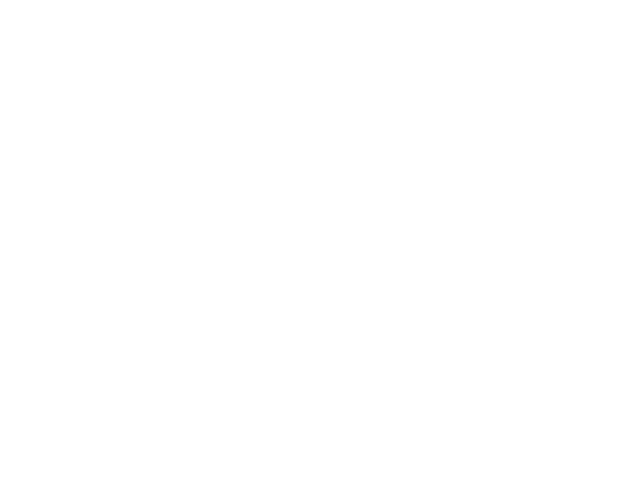

In [95]:
q_true = np.nanquantile(true.values.ravel(), quantiles)
q_simu = np.nanquantile(simulated.values.ravel(), quantiles)
plt.figure()
plt.plot(q_true, q_simu, 'x')
plt.plot(q_true, q_true)

<IPython.core.display.Javascript object>


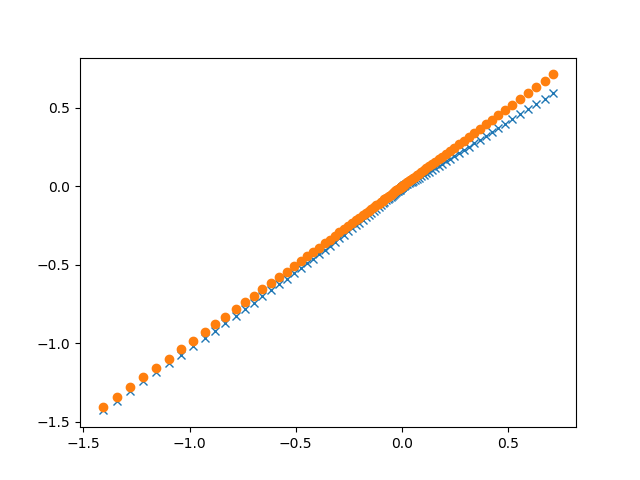

In [96]:
plt.figure()
plt.plot(q_true, q_simu, 'x')
plt.plot(q_true, q_true, 'o')

In [227]:
simulated.shape

(50, 290, 900)

Quantiles analysis

<IPython.core.display.Javascript object>


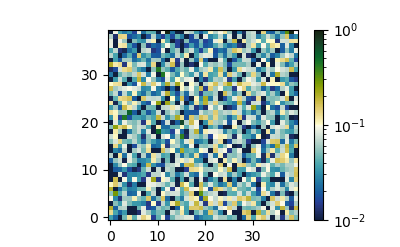

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  


In [249]:
import matplotlib
import cmocean
mean_pred = p0 * mu0 + p1 * mu1
plt.figure()
plt.imshow(np.abs((mean_pred.mean(dim='time') - true.mean(dim='time'))) / true.std(dim='time'), vmin=0.01, vmax=1, norm=matplotlib.colors.LogNorm()
, origin='lower', cmap=cmocean.cm.delta)
plt.colorbar()